# Training and calculating sharpness

In this notebook we provide two examples of training the model and calculating the sharpness of the minimum obtained. Both examples are on FashionMNIST dataset, with *SimpleBatch* architecture (neural network with 6 convolutional layers, 2 linear layers and batch normalization). The first example uses SGD optimizer, while the second example uses Sharpness Aware Minimization (SAM) with SGD optimizer as a background optimizer. Each of these can be easily changed in the notebook and this notebook is desinged to demonstrate the usage of functions. 

For systematical trainings and sharpness calculations, you can run either the bash files withinthe repository or refer to runnig main.py according to the README instructions.

## Drive mouting and imports

In [1]:
# libraries import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.datasets import FashionMNIST

import matplotlib.pyplot as plt
import random
from itertools import product
import sys 
import os
from datetime import datetime

# setting the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
# import of models and other helpers
from models import *
from helpers import *

# optimizer imports that can be used for additional runs
from optimizers.adashift import AdaShift            # code taken from: https://github.com/MichaelKonobeev/adashift
from optimizers.adabound import AdaBound            # code taken from: https://github.com/Luolc/AdaBound
from optimizers.sam import SAM                      # code taken from: https://github.com/davda54/sam

# import functions for calculating sharpness 
from sharpness.Minimum import effective as minimum_shaprness_eff        # code taken from: https://github.com/ibayashi-hikaru/minimum-sharpness

# getting the path to checkpoint folder from helpers file
checkpoints_dir = 'checkpoints_test'

Here, we specify which architecture, dataset and maximal epoch number we use. In order to do training for different architecture or dataset, only this cell should be changed.

In [3]:
ARCHITECTURE = 'SimpleBatch'                                    # Other possibilities: 'MiddleBatch', 'ComplexBatch'
DATASET = 'FashionMNIST'                                        # Other possibilities: 'CIFAR10'
MAX_EPOCH = 200                                                 # Our trainings are done for 200 epochs
TRAIN_BATCH_SIZE = 2**7

# location to store current configuration results
store_dir = os.path.join(checkpoints_dir, f'{DATASET}/{ARCHITECTURE}')
print(store_dir)

checkpoints_test/FashionMNIST/SimpleBatch


## Loading the dataset and creating dataloaders

In [4]:
VAL_BATCH_SIZE = 1000

if DATASET == 'CIFAR10':
    #loading datasets
    train_data =  CIFAR10('./data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(), # ToTensor does min-max normalization. 
    ]), )

    test_data = CIFAR10('./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(), # ToTensor does min-max normalization. 
    ]), )

    #creating dataLoaders
    train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=TRAIN_BATCH_SIZE)
    test_loader = dataloader.DataLoader(test_data, shuffle=False, batch_size=VAL_BATCH_SIZE)

if DATASET == 'FashionMNIST':
    #loading datasets
    train_data =  FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(), # ToTensor does min-max normalization. 
    ]), )

    test_data = FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(), # ToTensor does min-max normalization. 
    ]), )

    #creating dataLoaders
    train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=TRAIN_BATCH_SIZE)
    test_loader = dataloader.DataLoader(test_data, shuffle=False, batch_size=VAL_BATCH_SIZE)   

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
data = preprocess_data_for_sharpness(train_data, DATASET, device)

Preporcessing dataset FashionMNIST in order to calculate sharpness...
Time needed 0:00:08.131259


/home/ina/Repos/OptML/helpers.py:214: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(train_data.targets)


## Training model on SGD without SAM


In [ ]:
# Getting the model based on the architecture and the dataset
model = get_model(ARCHITECTURE, DATASET).to(device)

# Specifying the optimizer. This can be changed to any optimizer that is supported by PyTorch.
# In order to use AdaBound:   optimizer = AdaBound(model.parameters())
# In order to use AdaShift:   optimizer = AdaShift(model.parameters())
# In order to use PHB:        optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.8)
# In order to use Adagrad:    optimizer = torch.optim.Adagrad(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer_name = 'SGD'

model = train(model, optimizer, train_loader=train_loader, device=device, epoch_num=MAX_EPOCH, max_nbr_epochs=MAX_EPOCH, path=optimizer_name, val_dataloader=test_loader, sam=False, dir_path=store_dir)

new version 2
 Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.379745	 accuracy: 86.46%	 Time: 0:00:06.316012
	 Test loss: 0.324387663602829 	 Test accuracy: 88.04000091552734

 Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.258497	 accuracy: 90.68%	 Time: 0:00:06.137482
	 Test loss: 0.2614754170179367 	 Test accuracy: 90.52999877929688

 Train Epoch: 2 [60000/60000 (100%)]	Loss: 0.217269	 accuracy: 92.01%	 Time: 0:00:06.212931
	 Test loss: 0.24827186167240142 	 Test accuracy: 91.0

 Train Epoch: 3 [60000/60000 (100%)]	Loss: 0.187217	 accuracy: 93.18%	 Time: 0:00:06.872480
	 Test loss: 0.2555343255400658 	 Test accuracy: 91.11000061035156

 Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.162010	 accuracy: 94.06%	 Time: 0:00:06.174041
	 Test loss: 0.22924970090389252 	 Test accuracy: 91.86000061035156

 Train Epoch: 5 [60000/60000 (100%)]	Loss: 0.139343	 accuracy: 94.91%	 Time: 0:00:06.108058
	 Test loss: 0.23696358650922775 	 Test accuracy: 91.8699951171875

 Train Epoch: 6 [60000/60000 (100%)]	L

In [ ]:
lr = 0.1 if DATASET == 'FashionMNIST' else 1
num_epochs = 100000
batch_size = 128

computed = False

path = os.path.join(store_dir, 'epoch200', optimizer_name + '.pt')
checkpoint = torch.load(path, map_location=torch.device('cpu'))
model = checkpoint['state_dict']
model = get_model(ARCHITECTURE, DATASET).to(device)
model.load_state_dict(checkpoint['state_dict'])


while not computed:
    try:
        # Calculating the sharpness. Returns an error if the learning rate is too big
        sharpnesses, losses = minimum_shaprness_eff(data, model, batch_size, lr, num_epochs=num_epochs, optimizer_file=path)

        # storing the sharpness
        sharpness_path = os.path.join(store_dir, 'epoch200', optimizer_name + '_sharpness.pt')
        checkpoint = {'sharpnesses':sharpnesses, 'sharpness':sharpnesses[-1], 'losses': losses}
        torch.save(checkpoint, sharpness_path)


        computed = True
        print(f'Sharpness: {sharpnesses[-1]}')
    except:
        # Error is returned if the learning rate is too big, so in that case learning rate is set to be twice smaller and number of epochs are set to be twice as bigger
        computed = False
        lr /= 2.0
        num_epochs *= 2
        print(f'Use smaller stepsize than {lr}')

	 Calculating Hessian


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


	Finished the diag calculation. Time needed: 0:00:59.205600. Computing sharpness...
 		 epoch:100000	 processed 100.0%	 loss:0.011053657309945586 	 minimum sharpness: 108900.66487971791 	 Time needed 0:01:45.861625
--------------------------------------------------
Sharpness: 108900.66487971791


## Training with SAM

In [ ]:
model = get_model(ARCHITECTURE, DATASET).to(device)

# Specifying the background-optimizer of SAM. This can be changed to any optimizer that is supported by PyTorch. Examples:
# In order to use PHB:        optimizer = SAM(model.parameters(), torch.optim.SGD, lr=0.1, momentum=0.8)
# In order to use Adam:       optimizer = SAM(model.parameters(), torch.optim.Adam)
# In order to use AdaBound:   optimizer = SAM(model.parameters(), AdaBound)
# In order to use AdaShift:   optimizer = SAM(model.parameters(), AdaShift)
optimizer = SAM(model.parameters(), torch.optim.SGD, lr=0.1)

sam_optimizer_name = 'SAM_' + optimizer_name
model = train(model, optimizer, train_loader=train_loader, device=device, epoch_num=MAX_EPOCH, max_nbr_epochs=MAX_EPOCH, path=sam_optimizer_name, val_dataloader=test_loader, sam=True, dir_path=store_dir)

new version 2
 Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.461048	 accuracy: 83.57%	 Time: 0:00:09.832774
	 Test loss: 0.3120079696178436 	 Test accuracy: 88.6199951171875

 Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.311164	 accuracy: 88.77%	 Time: 0:00:10.131190
	 Test loss: 0.26722029894590377 	 Test accuracy: 90.3499984741211

 Train Epoch: 2 [60000/60000 (100%)]	Loss: 0.273540	 accuracy: 90.00%	 Time: 0:00:09.600028
	 Test loss: 0.2555205300450325 	 Test accuracy: 90.5

 Train Epoch: 3 [60000/60000 (100%)]	Loss: 0.245635	 accuracy: 91.10%	 Time: 0:00:09.443238
	 Test loss: 0.2255650833249092 	 Test accuracy: 91.83999633789062

 Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.224806	 accuracy: 91.83%	 Time: 0:00:09.344006
	 Test loss: 0.21657753735780716 	 Test accuracy: 92.25

 Train Epoch: 5 [60000/60000 (100%)]	Loss: 0.203977	 accuracy: 92.59%	 Time: 0:00:09.324913
	 Test loss: 0.21508579403162004 	 Test accuracy: 92.06999969482422

 Train Epoch: 6 [60000/60000 (100%)]	Loss: 0.18895

	 Calculating Hessian


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


	Finished the diag calculation. Time needed: 0:01:01.459540. Computing sharpness...
 		 epoch:100000	 processed 100.0%	 loss:0.016041555268829076 	 minimum sharpness: 28238.661864613856 	 Time needed 0:01:46.752965
--------------------------------------------------


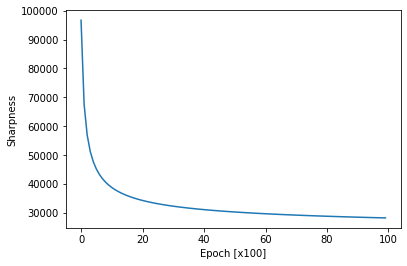

Sharpness: 28238.661864613856


In [ ]:
lr = 0.1 if DATASET == 'FashionMNIST' else 1
num_epochs = 100000
computed = False
batch_size = 128

path = os.path.join(store_dir, 'epoch200', sam_optimizer_name + '.pt')
checkpoint = torch.load(path, map_location=torch.device('cpu'))
model = checkpoint['state_dict']
model = get_model(ARCHITECTURE, DATASET).to(device)
model.load_state_dict(checkpoint['state_dict'])


while not computed:
    try:
        # Calculating the sharpness. Returns an error if the learning rate is too big
        sharpnesses, losses = minimum_shaprness_eff(data, model, batch_size, lr, num_epochs=num_epochs, optimizer_file=path)

        # storing the sharpness
        sharpness_path = os.path.join(store_dir, 'epoch200', sam_optimizer_name + '_sharpness.pt')
        checkpoint = {'sharpnesses':sharpnesses, 'sharpness':sharpnesses[-1], 'losses': losses}
        torch.save(checkpoint, sharpness_path)

        # Plotting sharpness as an objective function being minimized during time
        plt.ylabel('Sharpness')
        plt.xlabel('Epoch [x100]')
        plt.plot(sharpnesses)
        plt.show()


        computed = True
        print(f'Sharpness: {sharpnesses[-1]}')
    except:
        # Error is returned if the learning rate is too big, so in that case learning rate is set to be twice smaller and number of epochs are set to be twice as bigger
        computed = False
        lr /= 2.0
        num_epochs *= 2
        print(f'Use smaller stepsize than {lr}')

## Loading the data

Here we demonstrate how to load the data. We compare here SGD and SAM with SGD. Plots used in the report are shown in the *Data analysis* notebook.

Minimum sharpness of SGD: 108900.66487971791
Minimum sharpness of SAM: 28238.661864613856


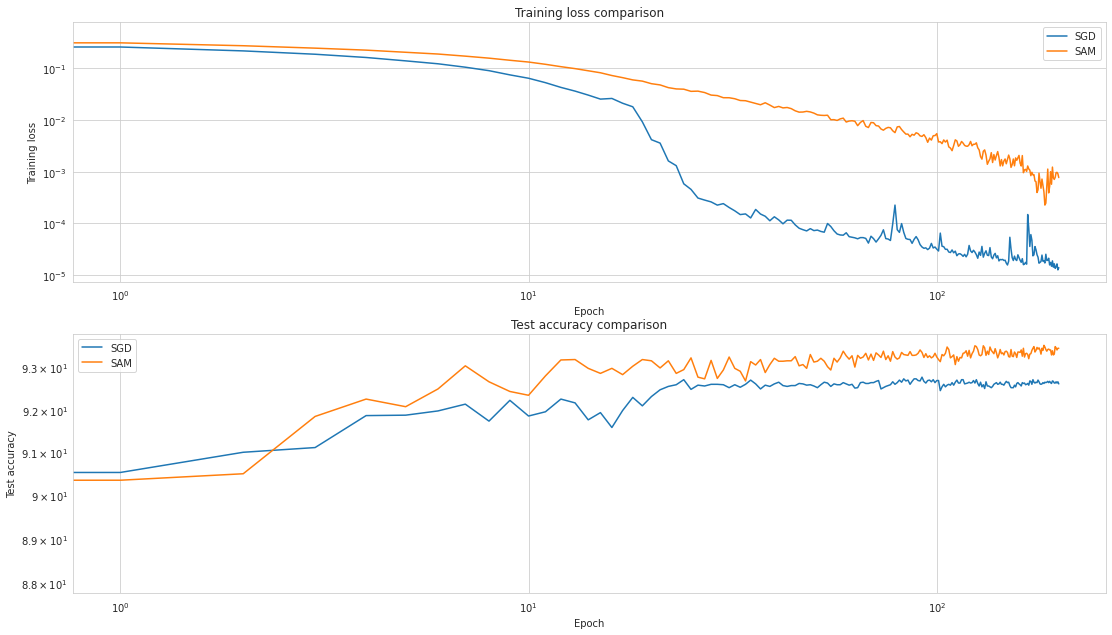

In [9]:
# Loading information about SGD training
checkpoint_sgd = torch.load(os.path.join(store_dir, 'epoch200', optimizer_name + '.pt'), map_location=torch.device('cpu'))
losses_sgd = checkpoint_sgd['training_loss']
acc_sgd = checkpoint_sgd['validation_accuracy']
sharpness_sgd = torch.load(os.path.join(store_dir, 'epoch200', optimizer_name + '_sharpness.pt'))['sharpness']

# Loading information about SAM SGD training
#checkpoint_sam = torch.load(os.path.join(store_dir, 'epoch200', 'SAM_SGD.pt'), map_location=torch.device('cpu'))
checkpoint_sam = torch.load(os.path.join(store_dir, 'epoch200', sam_optimizer_name + '.pt'), map_location=torch.device('cpu'))
losses_sam = checkpoint_sam['training_loss']
acc_sam = checkpoint_sam['validation_accuracy']
sharpness_sam = torch.load(os.path.join(store_dir, 'epoch200', sam_optimizer_name + '_sharpness.pt'))['sharpness']

# Plotting both
fig, ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5, forward=True)

ax[0].set_title("Training loss comparison")
ax[0].loglog(losses_sgd, label='SGD')
ax[0].loglog(losses_sam, label='SAM')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training loss')
ax[0].legend()

ax[1].set_title("Test accuracy comparison")
ax[1].loglog(acc_sgd, label='SGD')
ax[1].loglog(acc_sam, label='SAM')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Test accuracy')
ax[1].legend()

# Writing sharpness
print(f'Minimum sharpness of SGD: {sharpness_sgd}')
print(f'Minimum sharpness of SAM: {sharpness_sam}')